# <center>Projet 8 : Déployer un modèle dans le cloud

**Introduction**

Notre mission pour ce projet consiste à développer dans un environnement Big Data une première chaîne de traitement des données qui comprendra le preprocessing et une étape de réduction de dimension pour une startup Fruits de l'AgriTech pour mettre à disposition du grand public une application mobile qui permettrait aux utilisateurs de prendre en photo un fruit et d'obtenir des informations sur ce fruit.

# 1. Chargement des modules

In [0]:
pip install tensorflow

Python interpreter will be restarted.
  Attempting uninstall: MarkupSafe
    Found existing installation: MarkupSafe 2.0.1
    Not uninstalling markupsafe at /databricks/python3/lib/python3.8/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-37695936-1277-47de-b4c0-0b4a6e38416f
    Can't uninstall 'MarkupSafe'. No files were found to uninstall.
Python interpreter will be restarted.


In [0]:
# Chargement des librairies
import datetime
import io
import sys
import time
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# Pyspark
import pyspark
from pyspark.sql.functions import element_at, split, col, pandas_udf, PandasUDFType, udf
from pyspark.sql.types import StringType

# Tensorflow Keras
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Gestion des images
import PIL
from PIL import Image

# Taches ML
from pyspark.ml.image import ImageSchema

# Réduction de dimension - PCA
from pyspark.ml.feature import PCA
from pyspark.ml.feature import StandardScaler
from pyspark.ml.linalg import Vectors, VectorUDT, DenseVector

# Modélisation
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# 2. Chargement des données

## 2.1 Train set - format "image"

On compte charger seulement quelques répertoires d'images du train set pour tester les scripts pyspark avant la mise en production et gagner en ressources et en temps de réponses.

In [0]:
# Chemin de stockage des images
path = '/FileStore/tables/data/**'

In [0]:
# Charger en format 'image' des images du train set
image_train = spark.read.format('image').load(path, inferschema=True) 

In [0]:
# Schéma
image_train.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)



In [0]:
# Nombre d'images
print(image_train.count())

792


In [0]:
# Afficher les images
display(image_train.head(5))

image
"List(dbfs:/FileStore/tables/data/r1_288__2_.jpg, 435, 540, 3, 16, //////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////8= (truncated))"
"List(dbfs:/FileStore/tables/data/r1_300__2_.jpg, 434, 532, 3, 16, //////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////8= (truncated))"
"List(dbfs:/FileStore/tables/data/r0_324.jpg, 526, 421, 3, 16, //////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////8= (truncated))"
"List(dbfs:/FileStore/tables/data/r1_290__2_.jpg, 435, 538, 3, 16, //////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////8= (truncated))"
"List(dbfs:/FileStore/tables/data/r1_276__2_.jpg, 434, 538, 3, 16, //////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////8= (truncated))"


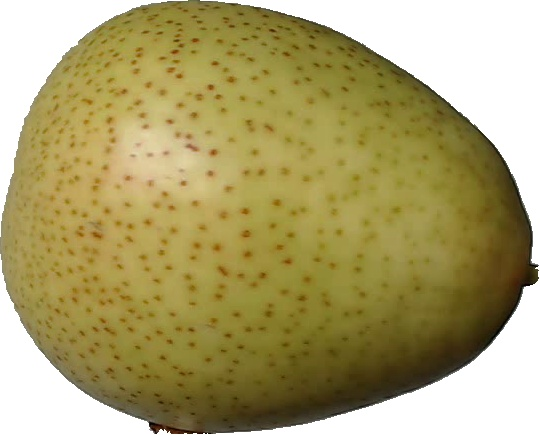

In [0]:
# Affiche la première image du dataframe
# Transforme de format bianire en Array avec RGB mode
ImageArray_first = ImageSchema.toNDArray(image_train.first()['image'])[:, :, ::-1]
Image.fromarray(ImageArray_first)

(90, 90, 87)


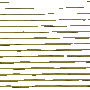

In [0]:
#affichage d'une image
import numpy as np
a = image_train.first()
b = np.array(a.asDict()['image']['data']).reshape(90,90,87)[:,:,::-1]
print(b.shape)
Image.fromarray(b, 'RGB')

In [0]:
# Visualisation des images - 20 premières (par défaut)
image_train.show()

+--------------------+
|               image|
+--------------------+
|{dbfs:/FileStore/...|
|{dbfs:/FileStore/...|
|{dbfs:/FileStore/...|
|{dbfs:/FileStore/...|
|{dbfs:/FileStore/...|
|{dbfs:/FileStore/...|
|{dbfs:/FileStore/...|
|{dbfs:/FileStore/...|
|{dbfs:/FileStore/...|
|{dbfs:/FileStore/...|
|{dbfs:/FileStore/...|
|{dbfs:/FileStore/...|
|{dbfs:/FileStore/...|
|{dbfs:/FileStore/...|
|{dbfs:/FileStore/...|
|{dbfs:/FileStore/...|
|{dbfs:/FileStore/...|
|{dbfs:/FileStore/...|
|{dbfs:/FileStore/...|
|{dbfs:/FileStore/...|
+--------------------+
only showing top 20 rows



In [0]:
# Visualisation nom de la première image
image_train.select('image.origin').show(1, False)

+------------------------------------------+
|origin                                    |
+------------------------------------------+
|dbfs:/FileStore/tables/data/r1_288__2_.jpg|
+------------------------------------------+
only showing top 1 row



In [0]:
# Visualisation du répertoire et dimension es 20 premières images
image_train.select("image.origin", "image.width", "image.height").show(truncate=False)

+------------------------------------------+-----+------+
|origin                                    |width|height|
+------------------------------------------+-----+------+
|dbfs:/FileStore/tables/data/r1_288__2_.jpg|540  |435   |
|dbfs:/FileStore/tables/data/r1_300__2_.jpg|532  |434   |
|dbfs:/FileStore/tables/data/r0_324.jpg    |421  |526   |
|dbfs:/FileStore/tables/data/r1_290__2_.jpg|538  |435   |
|dbfs:/FileStore/tables/data/r1_276__2_.jpg|538  |434   |
|dbfs:/FileStore/tables/data/r1_286__2_.jpg|537  |435   |
|dbfs:/FileStore/tables/data/r1_312.jpg    |525  |433   |
|dbfs:/FileStore/tables/data/r1_284__2_.jpg|539  |435   |
|dbfs:/FileStore/tables/data/r1_298__2_.jpg|534  |434   |
|dbfs:/FileStore/tables/data/r0_288__2_.jpg|435  |526   |
|dbfs:/FileStore/tables/data/r1_264__2_.jpg|554  |433   |
|dbfs:/FileStore/tables/data/r1_296__2_.jpg|535  |434   |
|dbfs:/FileStore/tables/data/r1_282__2_.jpg|541  |435   |
|dbfs:/FileStore/tables/data/r1_280__2_.jpg|539  |434   |
|dbfs:/FileSto

## 2.2. Labellisation - extraction de la classe de l'image

- La classe de l'image traitée est définie dans le nom du répertoire de l'image.

In [0]:
# Ajout dans la colonne Classe pour chaque image traitée de l'avant dernier élément
image_train = image_train.withColumn("Classe", element_at(split(image_train["image.origin"], "/"), -2))

In [0]:
# Schéma
image_train.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = true)
 |    |-- width: integer (nullable = true)
 |    |-- nChannels: integer (nullable = true)
 |    |-- mode: integer (nullable = true)
 |    |-- data: binary (nullable = true)
 |-- Classe: string (nullable = true)



In [0]:
# Visualisation des 20 premières images
image_train.show()

+--------------------+------+
|               image|Classe|
+--------------------+------+
|{dbfs:/FileStore/...|  data|
|{dbfs:/FileStore/...|  data|
|{dbfs:/FileStore/...|  data|
|{dbfs:/FileStore/...|  data|
|{dbfs:/FileStore/...|  data|
|{dbfs:/FileStore/...|  data|
|{dbfs:/FileStore/...|  data|
|{dbfs:/FileStore/...|  data|
|{dbfs:/FileStore/...|  data|
|{dbfs:/FileStore/...|  data|
|{dbfs:/FileStore/...|  data|
|{dbfs:/FileStore/...|  data|
|{dbfs:/FileStore/...|  data|
|{dbfs:/FileStore/...|  data|
|{dbfs:/FileStore/...|  data|
|{dbfs:/FileStore/...|  data|
|{dbfs:/FileStore/...|  data|
|{dbfs:/FileStore/...|  data|
|{dbfs:/FileStore/...|  data|
|{dbfs:/FileStore/...|  data|
+--------------------+------+
only showing top 20 rows



## 2.3. Train set - format "binaryFile"

Databricks recommande d’utiliser la source de données de fichier binaire pour charger des données d’image dans le tableau Spark en tant qu’octets bruts.

In [0]:
# Chemin de stockage des images
path = '/FileStore/tables/data/**'

In [0]:
# Chargement des images du train set au format "binaryFile"
binary_train = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(path)

In [0]:
# Schéma
binary_train.printSchema()

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)



In [0]:
# Nombre d'images
binary_train.count()

Out[18]: 792

In [0]:
# Visualisation des 20 premières images
binary_train.show()

+--------------------+-------------------+------+--------------------+
|                path|   modificationTime|length|             content|
+--------------------+-------------------+------+--------------------+
|dbfs:/FileStore/t...|2022-10-01 17:02:46| 59182|[FF D8 FF E0 00 1...|
|dbfs:/FileStore/t...|2022-10-01 17:02:51| 59027|[FF D8 FF E0 00 1...|
|dbfs:/FileStore/t...|2022-10-01 17:00:48| 57905|[FF D8 FF E0 00 1...|
|dbfs:/FileStore/t...|2022-10-01 17:02:47| 57294|[FF D8 FF E0 00 1...|
|dbfs:/FileStore/t...|2022-10-01 17:02:41| 57263|[FF D8 FF E0 00 1...|
|dbfs:/FileStore/t...|2022-10-01 17:02:45| 57262|[FF D8 FF E0 00 1...|
|dbfs:/FileStore/t...|2022-10-01 17:02:55| 57050|[FF D8 FF E0 00 1...|
|dbfs:/FileStore/t...|2022-10-01 17:02:44| 57047|[FF D8 FF E0 00 1...|
|dbfs:/FileStore/t...|2022-10-01 17:02:50| 56784|[FF D8 FF E0 00 1...|
|dbfs:/FileStore/t...|2022-10-01 17:00:29| 56531|[FF D8 FF E0 00 1...|
|dbfs:/FileStore/t...|2022-10-01 17:02:36| 56510|[FF D8 FF E0 00 1...|
|dbfs:

## 2.4. Labellisation - extraction de la classe de l'image

- La classe de l'image traitée est définie dans le nom du répertoire de l'image.

In [0]:
# Ajout dans la colonne Classe pour chaque image traitée de l'avant dernier élément
binary_train = binary_train.withColumn("Classe", element_at(split(binary_train["path"], "/"), -2))

In [0]:
# Schéma
binary_train.printSchema()

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- Classe: string (nullable = true)



In [0]:
# Visualisation des 20 premières images avec la classe
binary_train.show()

+--------------------+-------------------+------+--------------------+------+
|                path|   modificationTime|length|             content|Classe|
+--------------------+-------------------+------+--------------------+------+
|dbfs:/FileStore/t...|2022-10-01 17:02:46| 59182|[FF D8 FF E0 00 1...|  data|
|dbfs:/FileStore/t...|2022-10-01 17:02:51| 59027|[FF D8 FF E0 00 1...|  data|
|dbfs:/FileStore/t...|2022-10-01 17:00:48| 57905|[FF D8 FF E0 00 1...|  data|
|dbfs:/FileStore/t...|2022-10-01 17:02:47| 57294|[FF D8 FF E0 00 1...|  data|
|dbfs:/FileStore/t...|2022-10-01 17:02:41| 57263|[FF D8 FF E0 00 1...|  data|
|dbfs:/FileStore/t...|2022-10-01 17:02:45| 57262|[FF D8 FF E0 00 1...|  data|
|dbfs:/FileStore/t...|2022-10-01 17:02:55| 57050|[FF D8 FF E0 00 1...|  data|
|dbfs:/FileStore/t...|2022-10-01 17:02:44| 57047|[FF D8 FF E0 00 1...|  data|
|dbfs:/FileStore/t...|2022-10-01 17:02:50| 56784|[FF D8 FF E0 00 1...|  data|
|dbfs:/FileStore/t...|2022-10-01 17:00:29| 56531|[FF D8 FF E0 00

# 3. Extraction des features importantes pour chaque image

- Nous allons extraire les features les plus importantes pour la classification de nos images en utilisant un modèle [InceptionV3] de deep learning pré-entrainé sur de la classification d'images.
- Comme le but de ce projet n'est pas d'effectuer la classification; La dernière couche (softmax), qui effectue la classification, est supprimée à l'aide du paramètre (include_top=False). Cela nous permettra de choisir un modèle de classification adapté à nos classes.

## 3.1. Préparation du dataframe de travail

Le dataframe de travail sera composé des colonnes utiles à partir du dataframe des images binaires :
- le répertoire de stockage de l'image (colonne path),
- le label (colonne Classe) de chaque image,
- les features les plus importantes ajoutées après exécution du modèle (étape 3.3.).

In [0]:
df_images = binary_train.select("path", "Classe")
df_images.show()

+--------------------+------+
|                path|Classe|
+--------------------+------+
|dbfs:/FileStore/t...|  data|
|dbfs:/FileStore/t...|  data|
|dbfs:/FileStore/t...|  data|
|dbfs:/FileStore/t...|  data|
|dbfs:/FileStore/t...|  data|
|dbfs:/FileStore/t...|  data|
|dbfs:/FileStore/t...|  data|
|dbfs:/FileStore/t...|  data|
|dbfs:/FileStore/t...|  data|
|dbfs:/FileStore/t...|  data|
|dbfs:/FileStore/t...|  data|
|dbfs:/FileStore/t...|  data|
|dbfs:/FileStore/t...|  data|
|dbfs:/FileStore/t...|  data|
|dbfs:/FileStore/t...|  data|
|dbfs:/FileStore/t...|  data|
|dbfs:/FileStore/t...|  data|
|dbfs:/FileStore/t...|  data|
|dbfs:/FileStore/t...|  data|
|dbfs:/FileStore/t...|  data|
+--------------------+------+
only showing top 20 rows



## 3.2. Préparation du modèle InceptionV3

Utilisation de la technique de transfert learning pour extraire les features de chaque image avec le modèle **[InceptionV3](https://keras.io/api/applications/inceptionv3/)** de la librairie Keras de tensorflow avec l'aide des recommandations de databricks sur l'utilisation du transfert learning.

***Note : Recommandation de databricks***
***
- Pandas UDFs on large records (e.g., very large images) can run into Out Of Memory (OOM) errors.
If you hit such errors in the cell below, try reducing the Arrow batch size via `maxRecordsPerBatch`.
`spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")`
- Pour les modèles de taille modérée (< 1 Go, c'est le cas de notre projet), une bonne pratique consiste à télécharger le modèle vers le pilote Spark, puis à diffuser les poids aux travailleurs. Ce carnet de notes utilise cette approche.
`bc_model_weights = sc.broadcast(model.get_weights())`
`model.set_weights(bc_model_weights.value)`

[lien](https://docs.databricks.com/_static/notebooks/deep-learning/deep-learning-transfer-learning-keras.html)

In [0]:
# Instanciation du modèle
model = InceptionV3(
        include_top=False,  # Couche softmax de classification supprimée
        weights='imagenet',  # Poids pré-entraînés sur Imagenet
        input_shape=(100,100,3), # Image de taille 100x100 en couleur (channel=3)
        pooling='max' # Utilisation du max de pooling
)

87910968/87910968 [==============================] - 1s 0us/step


In [0]:
# Description des caractéristiques du modèle
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 49, 49, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 49, 49, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

## 3.3. Extraction des features pour chaque image

### 3.3.1. Fonctions utiles à l'extraction des features

In [0]:
# Instanciation du modèle
model = InceptionV3(
        include_top=False,  # Couche softmax de classification supprimée
        weights='imagenet',  # Poids pré-entraînés sur Imagenet
        input_shape=(100,100,3), # Image de taille 100x100 en couleur (channel=3)
        pooling='max' # Utilisation du max de pooling
)

In [0]:
# Permettre aux workers Spark d'accéder aux poids utilisés par le modèle
bc_model_weights = spark.sparkContext.broadcast(model.get_weights())

In [0]:
def model_fn():
  """
  Renvoie un modèle Inception3 avec la couche supérieure supprimée et les poids pré-entraînés sur imagenet diffusés.
  """
  model = InceptionV3(
        include_top=False,  # Couche softmax de classification supprimée
        weights='imagenet',  # Poids pré-entraînés sur Imagenet
#         input_shape=(100,100,3), # Image de taille 100x100 en couleur (channel=3)
        pooling='max' # Utilisation du max de pooling
  )
  model.set_weights(bc_model_weights.value)
  
  return model

**Fonction de redimensionnement de l'image**

Les images à transmettre en entrée de InceptionV3 doivent entre de dimension (299,299, 3)

In [0]:
# Redimensionnement des images en 299x299
def preprocess(content):
    """
    Prétraite les octets de l'image brute pour la prédiction.
    param : content : objet image, obligatoire
    return : image redimensionnée en Array
    """
    # lecture + redimension (299x299) pour Xception
    img = PIL.Image.open(io.BytesIO(content)).resize([299, 299])
    # transforme l'image en Array     
    arr = img_to_array(img)
    return preprocess_input(arr)

**Extraction des features par le modèle dans un vecteur**

In [0]:
# Extraction des features par le modèle dans un vecteur
def featurize_series(model, content_series):
  """
  Featurise une pd.Series d'images brutes en utilisant le modèle d'entrée.
  param : 
    model : modèle à utiliser pour l'extraction, obligatoire.
    content_series : image redimensionnée (299, 299, 3) en Array
  :return: les features importantes de l'image en pd.Series.
  """
  input = np.stack(content_series.map(preprocess))
  # Prédiction du modèle
  preds = model.predict(input)
  # Pour certaines couches, les caractéristiques de sortie seront des tenseurs multidimensionnels.
  # Nous aplatissons les tenseurs de caractéristiques en vecteurs pour faciliter le stockage dans
  # les DataFrames de Spark.
  output = [p.flatten() for p in preds]
  
  return pd.Series(output)

In [0]:
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
  '''
  Cette méthode est un Scalar Iterator pandas UDF enveloppant notre fonction de featurisation.
  Le décorateur spécifie que cette méthode renvoie une colonne Spark DataFrame de type ArrayType(FloatType).
  
  :param content_series_iter : Cet argument est un itérateur sur des lots de données, où chaque lot est une série pandas de données d'image.
  '''
  # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
  # for multiple data batches.  This amortizes the overhead of loading big models.
  model = model_fn()
  for content_series in content_series_iter:
    yield featurize_series(model, content_series)

/databricks/spark/python/pyspark/sql/pandas/functions.py:386: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


### 3.3.2. Extraction des features pour chaque image du dataframe

In [0]:
# Les UDF de Pandas sur de grands enregistrements (par exemple, de très grandes images) peuvent rencontrer des erreurs de type Out Of Memory (OOM).
# Si vous rencontrez de telles erreurs dans la cellule ci-dessous, essayez de réduire la taille du lot Arrow via `maxRecordsPerBatch`.
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

In [0]:
# Nous pouvons maintenant exécuter la featurisation sur l'ensemble de notre DataFrame Spark.
# REMARQUE : Cela peut prendre beaucoup de temps (environ 10 minutes) car il applique un grand modèle à l'ensemble des données.
features_df = binary_train.repartition(16).select(col("path"), col('Classe'), featurize_udf("content").alias("features"))

In [0]:
# images
features_df.count()

Out[34]: 792

In [0]:
# Exemple des features
features_df.show()

+--------------------+------+--------------------+
|                path|Classe|            features|
+--------------------+------+--------------------+
|dbfs:/FileStore/t...|  data|[0.8297229, 0.650...|
|dbfs:/FileStore/t...|  data|[0.586697, 1.4248...|
|dbfs:/FileStore/t...|  data|[2.9186234, 1.560...|
|dbfs:/FileStore/t...|  data|[0.6399281, 1.178...|
|dbfs:/FileStore/t...|  data|[2.8955739, 1.195...|
|dbfs:/FileStore/t...|  data|[0.68930733, 0.39...|
|dbfs:/FileStore/t...|  data|[1.8057702, 0.380...|
|dbfs:/FileStore/t...|  data|[0.74305296, 0.62...|
|dbfs:/FileStore/t...|  data|[1.7574241, 2.489...|
|dbfs:/FileStore/t...|  data|[1.2508901, 0.245...|
|dbfs:/FileStore/t...|  data|[2.2355356, 1.325...|
|dbfs:/FileStore/t...|  data|[0.69654536, 0.50...|
|dbfs:/FileStore/t...|  data|[0.97320473, 0.87...|
|dbfs:/FileStore/t...|  data|[1.1586426, 0.146...|
|dbfs:/FileStore/t...|  data|[1.1354858, 1.147...|
|dbfs:/FileStore/t...|  data|[0.34400123, 0.84...|
|dbfs:/FileStore/t...|  data|[2

## 3.4. Réduction de dimension : PCA

### 3.4.1. Recherche meilleur nombre de composante

**Préprocessing des données**

In [0]:
def preprocess_pca(dataframe):
  '''
     Préparation des données :
     - transformation en vecteur dense
     - standardisation
     param : dataframe : dataframe d'images
     return : dataframe avec features vecteur dense standardisé
  '''
  
  # Préparation des données - conversion des données images en vecteur dense
  transform_vecteur_dense = udf(lambda r: Vectors.dense(r), VectorUDT())
  dataframe = dataframe.withColumn('features_vectors', transform_vecteur_dense('features'))
  
  # Standardisation obligatoire pour PCA
  scaler_std = StandardScaler(inputCol="features_vectors", outputCol="features_scaled", withStd=True, withMean=True)
  model_std = scaler_std.fit(dataframe)
  # Mise à l'échelle
  dataframe = model_std.transform(dataframe)
  
  return dataframe

**Recherche du nombre de composante expliquant 95% de la variance**

In [0]:
def recherche_nb_composante(dataframe, nb_comp=400):
    '''
       Recherche d nombre de composante expliquant 95% de la variance
       param : dataframe : dataframe d'images
       return : k nombre de composante expliquant 95% de la variance totale
    '''
    
    pca = PCA(k = nb_comp,
              inputCol="features_scaled", 
              outputCol="features_pca")
 
    model_pca = pca.fit(dataframe)
    variance = model_pca.explainedVariance
 
    # visuel
    plt.plot(np.arange(len(variance)) + 1, variance.cumsum(), c="blue", marker='o')
    plt.xlabel("Nb composantes")
    plt.ylabel("% variance")
    plt.show(block=False)
 
    def nb_comp ():
      for i in range(500):
          a = variance.cumsum()[i]
          if a >= 0.95:
              print("{} composantes principales expliquent 95% de la variance totale".format(i))
              break
      return i
 
    k=nb_comp()
  
    return k


In [0]:
# Pré-processing (vecteur dense, standardisation)
df_pca = preprocess_pca(features_df)

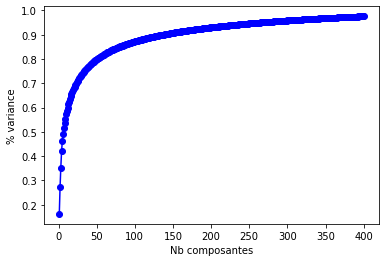

265 composantes principales expliquent 95% de la variance totale


In [0]:
# Nombre de composante expliquant 95% de la variance
n_components = recherche_nb_composante(df_pca)

### 3.4.2. Réduction de dimension PCA

In [0]:
# Entrainement de l'algorithme
pca = PCA(k=n_components, inputCol='features_scaled', outputCol='vectors_pca')
model_pca = pca.fit(df_pca)

# Transformation des images sur les k premières composantes
df_reduit = model_pca.transform(df_pca)

In [0]:
# Visualisation du dataframe réduit
df_reduit.show()

+--------------------+------+--------------------+--------------------+--------------------+--------------------+
|                path|Classe|            features|    features_vectors|     features_scaled|         vectors_pca|
+--------------------+------+--------------------+--------------------+--------------------+--------------------+
|dbfs:/FileStore/t...|  data|[0.8297229, 0.650...|[0.82972288131713...|[-0.6808722055477...|[-17.084929165401...|
|dbfs:/FileStore/t...|  data|[0.586697, 1.4248...|[0.58669698238372...|[-0.9964727414221...|[-16.157281995942...|
|dbfs:/FileStore/t...|  data|[2.9186234, 1.560...|[2.91862344741821...|[2.03183512705817...|[-15.194782304478...|
|dbfs:/FileStore/t...|  data|[0.6399281, 1.178...|[0.63992810249328...|[-0.9273452529302...|[-15.552370328714...|
|dbfs:/FileStore/t...|  data|[2.8955739, 1.195...|[2.89557385444641...|[2.00190225189749...|[-15.334013563950...|
|dbfs:/FileStore/t...|  data|[0.68930733, 0.39...|[0.68930733203887...|[-0.8632199421133

### 3.4.3. Sauvegarde des données

La dernière étape consiste à sauvegarder les données pré-traitées et réduites au format parquet.

In [0]:
# Sauvegarde des données
df_reduit.write.mode("overwrite").parquet("/FileStore/tables/output/resultats_parquet")